Setup

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import torch
import CNN

# from config_plots import global_settings
# global_settings()
import warnings
warnings.filterwarnings("ignore")

Hyper parameters

In [2]:
# defining global variables
experimentName = "test_22987_suffix50_11_CNN2_differentConfig_bestbaseline2"
showListOfSpecies = False

from configParser import ConfigParser, getModelName
config_parser = ConfigParser(experimentName)

import os
experimentName = os.path.join(experimentName, "multi-trial")
import TrialStatistics
ts = TrialStatistics.TrialStatistics(experimentName)
ts_genus = TrialStatistics.TrialStatistics(experimentName, "genus")

import dataLoader

Cuda support

In [3]:
# CUDA support 
if torch.cuda.is_available():
    torch.cuda.set_device(0) # 0
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    print("We are using cuda")

We are using cuda


Iterate

In [4]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from confusion_matrix_plotter import plot_confusion_matrix2, generate_classification_report
import numpy as np
import os
import progressbar

paramsIterator = config_parser.getHyperpIter()  
number_of_experiments = sum(1 for e in paramsIterator)
paramsIterator = config_parser.getHyperpIter()  
experiment_index = 0

datasetManager = dataLoader.datasetManager(experimentName, showListOfSpecies)
with progressbar.ProgressBar(max_value=number_of_experiments) as bar:
    for experiment_params in paramsIterator:
        bar.update(experiment_index)
        experiment_params["numOfTrials"] = experiment_params["numOfTrials"] or 1

        print("experiment ", experiment_index+1, "/", number_of_experiments, ": ", experiment_params)

        # load images
        datasetManager.updateParams(experiment_params)
        dataset = datasetManager.getDataset()
        speciesList = dataset.getSpeciesList()
        numberOfSpecies = len(speciesList)
        numberOfGenus = len(dataset.getGenusList())

        confusionMatricesPerTrial = []

        for i in range(experiment_params["numOfTrials"]):
            trialName = os.path.join(experimentName, getModelName(experiment_params, i))

            # Train/Load model
            architecture = {
                "species": numberOfSpecies,
                "genus" : numberOfGenus
            }
            model = CNN.create_model(architecture, experiment_params)
            train_loader, validation_loader, test_loader = datasetManager.getLoaders()
            if os.path.exists(CNN.getModelFile(trialName)):
                _, _, epochs, time_elapsed = CNN.loadModel(model, trialName)
                print("Model {0} loaded!".format(trialName))
            else:
                _, _, epochs, time_elapsed = CNN.trainModel(train_loader, validation_loader, experiment_params, model, trialName)
            
            # Update trial outcomes for statistics
            predlist, lbllist = CNN.getLoaderPredictions(test_loader, model, experiment_params)
            ts.addTrialPredictions(experiment_params, predlist, lbllist, numberOfSpecies)
            macro_f1 = f1_score(lbllist.cpu(), predlist.cpu(), average='macro')
            macro_f1_genus = np.nan
            if experiment_params["useHeirarchy"]:
                predlist, lbllist = CNN.getLoaderPredictions(test_loader, model, experiment_params, 'genus')
                ts_genus.addTrialPredictions(experiment_params, predlist, lbllist, numberOfGenus)
                macro_f1_genus = f1_score(lbllist.cpu(), predlist.cpu(), average='macro')

            ts.addTrial(experiment_params,
                    {'loss': CNN.getCrossEntropyFromLoader(test_loader, model, experiment_params),
                     'accuracy': CNN.getAccuracyFromLoader(test_loader, model, experiment_params),
                     'macro_f1_species': macro_f1,
                     'macro_f1_genus': macro_f1_genus,
                     'time': time_elapsed,
                     'epochs': epochs
                    }, i)
        
        experiment_index = experiment_index + 1

N/A% (0 of 2) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

experiment  1 / 2 :  {'image_path': '/data/BGNN_data/INHS_cropped', 'suffix': '50_11', 'training_count': 0.64, 'validation_count': 0.16, 'usePretrained': True, 'useHeirarchy': True, 'imageDimension': 224, 'n_channels': 3, 'useZCAWhitening': False, 'useNormalization': True, 'batchSize': 200, 'n_epochs': 1000, 'learning_rate': 0.001, 'numOfTrials': 2, 'patience': 100, 'kernels': [16, 32], 'kernelSize': 5}
file /data/BGNN_data/INHS_cropped/50_11/test_22987_suffix50_11_dataLoader3_heirarchy_compare_with_relu/multi-trial/tc0.640000_vc0.160000_d224_c3_zcaFalse_nTrue_ptTrue/dataset.pkl read
Loading saved dataloaders...
file /data/BGNN_data/INHS_cropped/50_11/test_22987_suffix50_11_dataLoader3_heirarchy_compare_with_relu/multi-trial/tc0.640000_vc0.160000_d224_c3_zcaFalse_nTrue_ptTrue/trainingLoader.pkl read
file /data/BGNN_data/INHS_cropped/50_11/test_22987_suffix50_11_dataLoader3_heirarchy_compare_with_relu/multi-trial/tc0.640000_vc0.160000_d224_c3_zcaFalse_nTrue_ptTrue/valLoader.pkl read
fil

N/A% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

Training started...


100% (1000 of 1000) |####################| Elapsed Time: 7:19:38 Time:  7:19:38


Early stopping
total number of epochs:  607


 50% (1 of 2) |#############             | Elapsed Time: 7:21:01 ETA:   0:00:10

experiment  2 / 2 :  {'image_path': '/data/BGNN_data/INHS_cropped', 'suffix': '50_11', 'training_count': 0.64, 'validation_count': 0.16, 'usePretrained': True, 'useHeirarchy': False, 'imageDimension': 224, 'n_channels': 3, 'useZCAWhitening': False, 'useNormalization': True, 'batchSize': 200, 'n_epochs': 1000, 'learning_rate': 0.001, 'numOfTrials': 2, 'patience': 100, 'kernels': [16, 32], 'kernelSize': 5}
using a pretrained resnet50 model...


N/A% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

Training started...


100% (1000 of 1000) |####################| Elapsed Time: 7:49:33 Time:  7:49:33


Early stopping
total number of epochs:  664


N/A% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

using a pretrained resnet50 model...
Training started...


100% (1000 of 1000) |###################| Elapsed Time: 10:45:19 Time: 10:45:19


Early stopping
total number of epochs:  905


100% (2 of 2) |#############| Elapsed Time: 1 day, 1:56:14 Time: 1 day, 1:56:14


Analyze

In [5]:
ts.showStatistics()
ts.saveStatistics()

Aggregated statistics


In [6]:
ts.showStatistics(False)
ts.saveStatistics(False)

Raw statistics


,image_path,suffix,training_count,validation_count,usePretrained,useHeirarchy,imageDimension,n_channels,useZCAWhitening,useNormalization,batchSize,n_epochs,learning_rate,numOfTrials,patience,kernels,kernelSize,loss,accuracy,time,epochs,hash,trial
0,/data/BGNN_data/INHS_cropped,50_11,0.64,0.16,True,True,224,3,False,True,200,1000,0.001,2,100,16 32,5,2.840756,0.354545,28603.872003,1.412501,-8989184222345607447,0
1,/data/BGNN_data/INHS_cropped,50_11,0.64,0.16,True,True,224,3,False,True,200,1000,0.001,2,100,16 32,5,2.356748,0.409091,26378.297989,608.000000,-8989184222345607447,1
2,/data/BGNN_data/INHS_cropped,50_11,0.64,0.16,True,False,224,3,False,True,200,1000,0.001,2,100,16 32,5,2.126083,0.436364,28173.081074,665.000000,-4159128359130336760,0
3,/data/BGNN_data/INHS_cropped,50_11,0.64,0.16,True,False,224,3,False,True,200,1000,0.001,2,100,16 32,5,2.362447,0.390909,38719.397080,906.000000,-4159128359130336760,1


In [ ]:
paramsIterator = config_parser.getHyperpIter() 
for experiment_params in paramsIterator:
    experiment_params["numOfTrials"] = experiment_params["numOfTrials"] or 1
    
    print("experiment: ", experiment_params)
    
    datasetManager.updateParams(experiment_params)
    dataset = datasetManager.getDataset()
    speciesList = dataset.getSpeciesList()
    ts.printTrialConfusionMatrix(experiment_params, speciesList, True)
    ts.printF1table(experiment_params, dataset)

experiment:  {'image_path': '/data/BGNN_data/INHS_cropped', 'suffix': '50_11', 'training_count': 0.64, 'validation_count': 0.16, 'usePretrained': True, 'useHeirarchy': True, 'imageDimension': 224, 'n_channels': 3, 'useZCAWhitening': False, 'useNormalization': True, 'batchSize': 200, 'n_epochs': 1000, 'learning_rate': 0.001, 'numOfTrials': 2, 'patience': 100, 'kernels': [16, 32], 'kernelSize': 5}


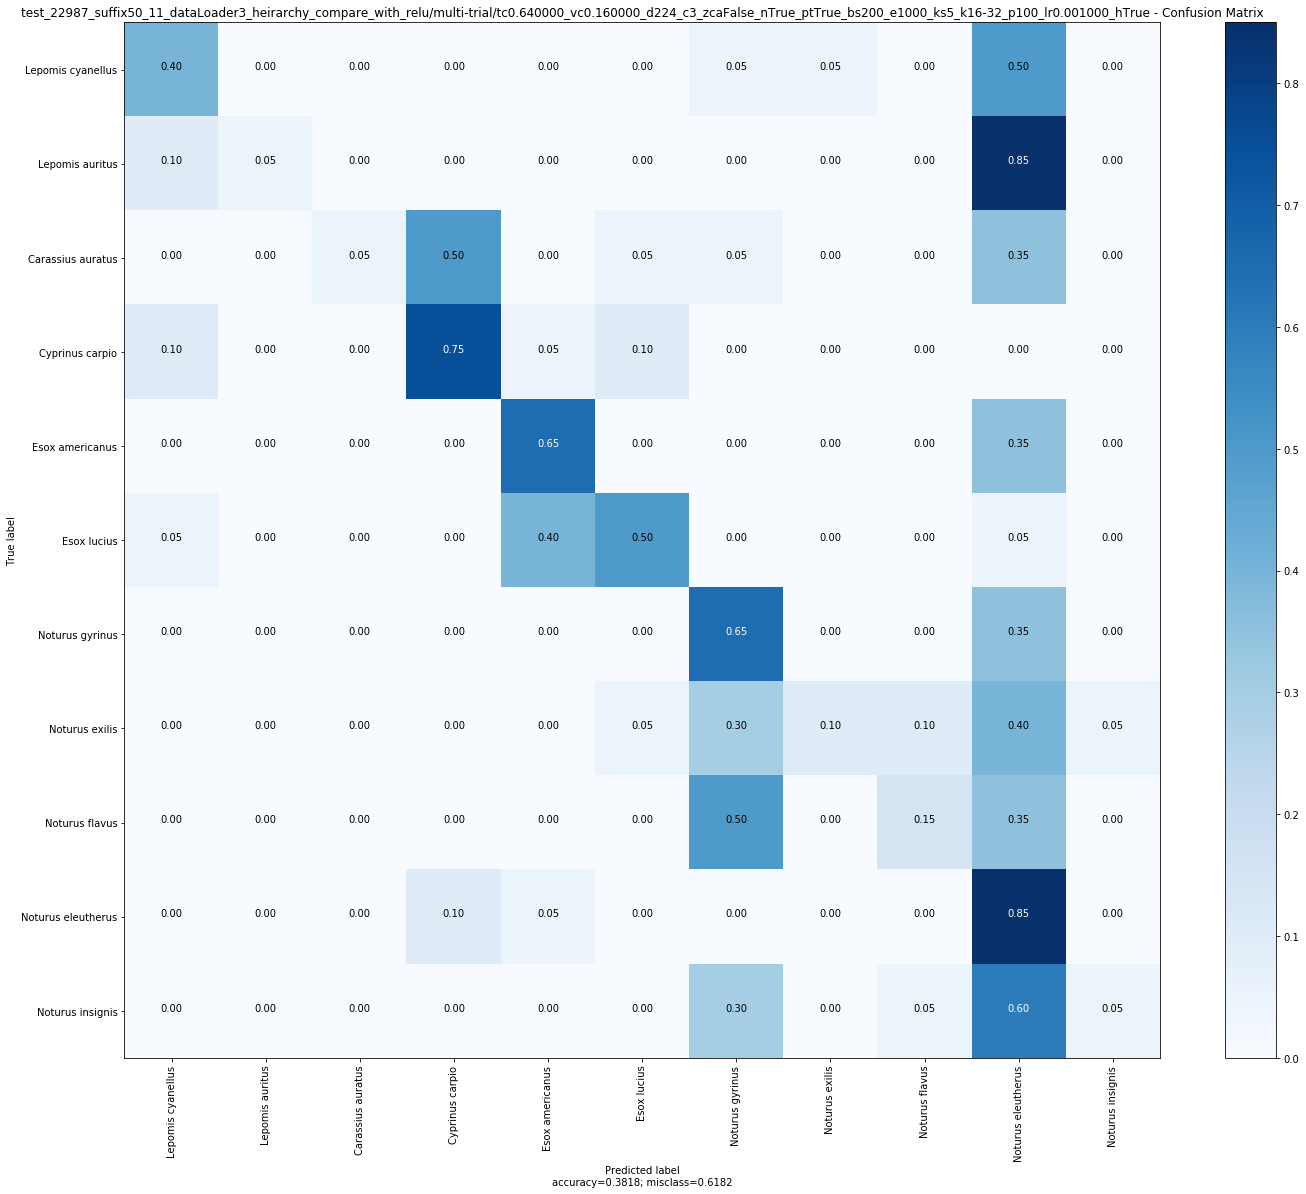

experiment:  {'image_path': '/data/BGNN_data/INHS_cropped', 'suffix': '50_11', 'training_count': 0.64, 'validation_count': 0.16, 'usePretrained': True, 'useHeirarchy': False, 'imageDimension': 224, 'n_channels': 3, 'useZCAWhitening': False, 'useNormalization': True, 'batchSize': 200, 'n_epochs': 1000, 'learning_rate': 0.001, 'numOfTrials': 2, 'patience': 100, 'kernels': [16, 32], 'kernelSize': 5}


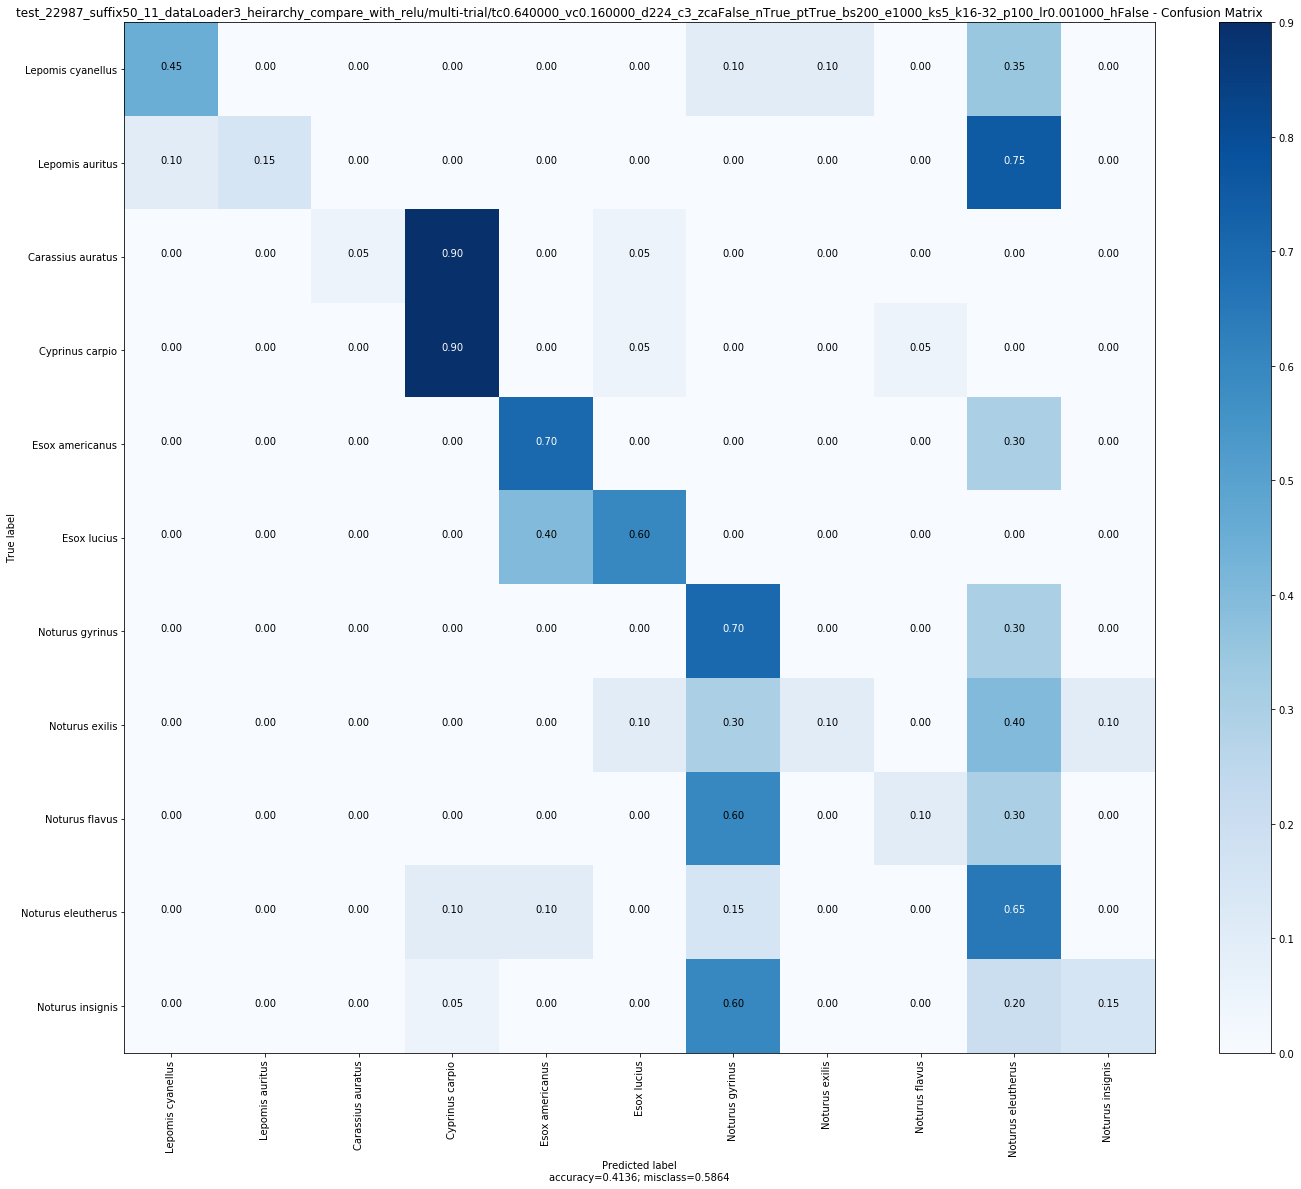

In [7]:
paramsIterator = config_parser.getHyperpIter() 
for experiment_params in paramsIterator:
    experiment_params["numOfTrials"] = experiment_params["numOfTrials"] or 1
    if experiment_params["useHeirarchy"]:
        print("experiment: ", experiment_params)

        datasetManager.updateParams(experiment_params)
        dataset = datasetManager.getDataset()
    
        genusList = dataset.getGenusList()
        ts_genus.printTrialConfusionMatrix(experiment_params, genusList, True)
        ts_genus.printF1table(experiment_params, dataset)

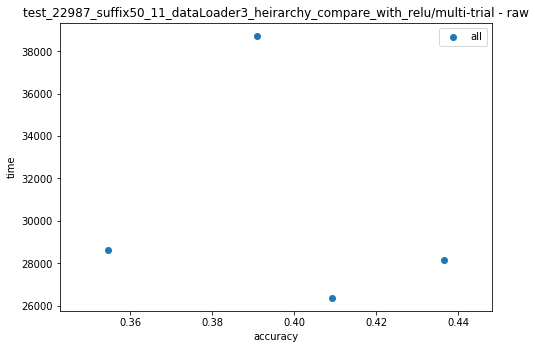

In [8]:
ts.trialScatter('accuracy', 'time', False)